In [ ]:
from utilities import init_bigquery_client
from google.cloud import bigquery
import os
import pandas as pd
import numpy as np
import plotly.express as px

#init BigQuery client
bq = init_bigquery_client()

## Bulk Query

In [ ]:
# Read from the 'user' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.users`
"""
users_df = bq.query(query).to_dataframe()

# Read from the 'friends' table in BigQuery
query = """
    SELECT *
    FROM `etl-testing-478716.firebase_etl_prod.friends`
"""
friends_df = bq.query(query).to_dataframe()


## Friend Graph

In [ ]:
#creating dataframe with parent_id and friend_id info merged
merged_df = friends_df.merge(users_df, left_on='parent_id', right_on='user_id', how='left', suffixes=('_friend', '_user'))
merged_df = merged_df.rename(columns={'fullName': 'fullName_parent', 'username': 'username_parent'})

#merge to get friend info
merged_df = merged_df.merge(users_df, left_on='friend_id', right_on='user_id', how='left', suffixes=('', '_user2'))


merged_df = merged_df.rename(columns={'fullName': 'fullName_friend', 'username': 'username_friend',
                                       'businessUser': 'businessUser_parent', 'businessUser_user2': 'businessUser_friend',
                                       'contactAccessGranted': 'contactAccessGranted_parent', 'contactAccessGranted_user2': 'contactAccessGranted_friend'})

#cleaning columns
columns_to_keep = ['parent_id', 'friend_id', 'fullName_parent','etl_loaded_at_friend', 'username_parent', 'businessUser_parent',
                   'contactAccessGranted_parent', 'fullName_friend', 'username_friend', 'businessUser_friend',
                   'contactAccessGranted_friend']
merged_df = merged_df.drop(columns=[x for x in merged_df.columns if x not in columns_to_keep])
#dropping rows with missing names (user may have deleted account)
merged_df = merged_df.dropna(subset=['fullName_parent', 'fullName_friend'])

In [ ]:
#How many ios users are not in the friends table?
ios_users_df = users_df[~users_df['username'].isna()]
ios_users_not_in_friends = ios_users_df[~ios_users_df['user_id'].isin(friends_df['parent_id']) | ~ios_users_df['user_id'].isin(friends_df['friend_id'])]

In [ ]:
ios_users_not_in_friends

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import scipy as sp

In [13]:
G = nx.from_pandas_edgelist(merged_df, 'parent_id', 'friend_id')

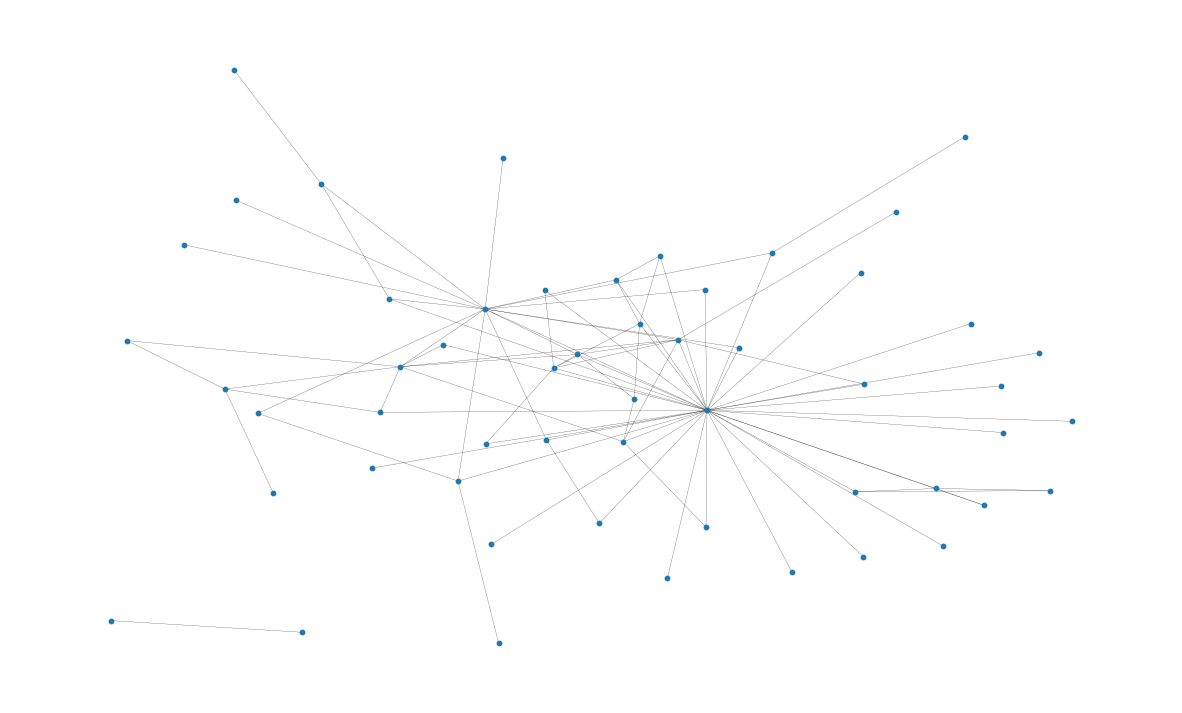

In [14]:
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

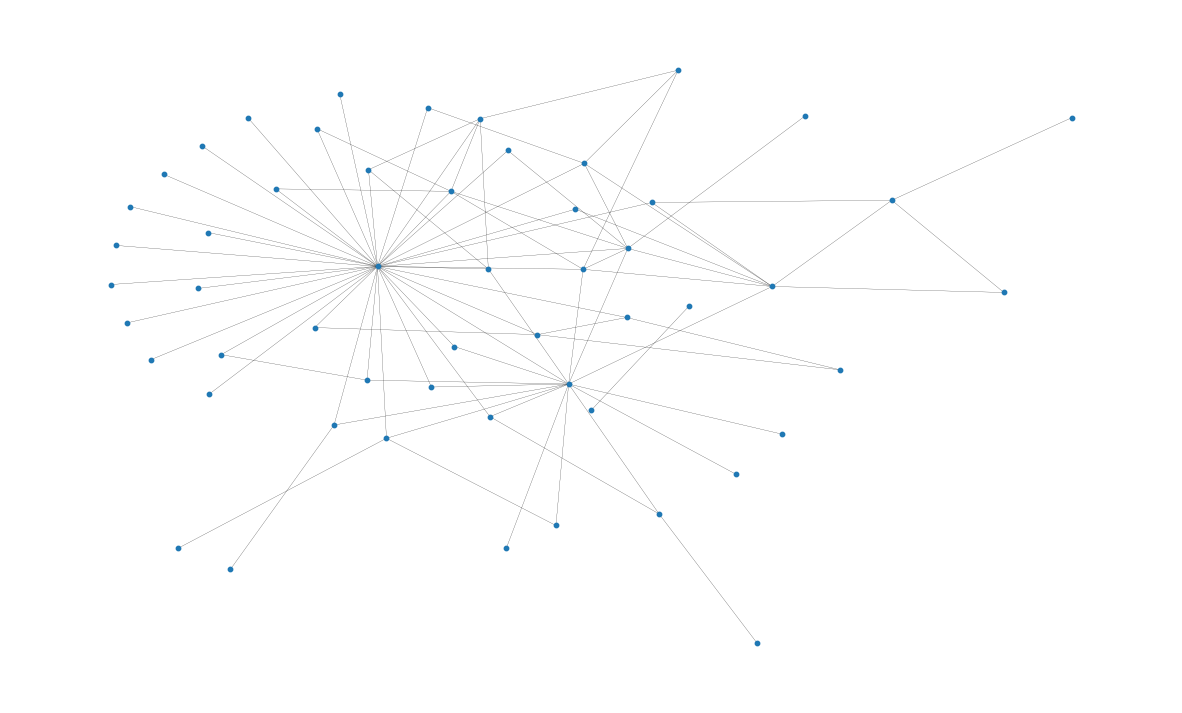

In [15]:
pos = nx.kamada_kawai_layout(G)
fig, ax = plt.subplots(figsize=(15, 9))
ax.axis("off")
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

### Network Overview 

In [ ]:
#Average degree per node
np.mean([d for _, d in G.degree()])

In [ ]:
#histogram of degree distribution

#TO DO try using plotnine
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)
degree_count = pd.Series(degree_sequence).value_counts().sort_index()
fig = px.histogram(degree_count, x=degree_count.index, y=degree_count.values,
             labels={'x': 'Degree', 'y': 'Count'}, nbins=30,
             title='Degree Distribution of Friend Network')
fig.show()

In [ ]:
#Shortest path lengths
shortest_path_lengths = dict(nx.all_pairs_shortest_path_length(G))

Diameter of network graph is the longest of the shortest paths between points in the connected graph. If the graph is not connected diameter is infinite. 

Larger diameter indicates a more spread-out or less efficient network

In [18]:
#diameter of the graph
diameter = max(nx.eccentricity(G, sp=shortest_path_lengths).values())
diameter

NetworkXError: Found infinite path length because the graph is not connected

In [16]:
# Compute the average shortest path length for each node
average_path_lengths = [
    np.mean(list(spl.values())) for spl in shortest_path_lengths.values()
]
# The average over all nodes
np.mean(average_path_lengths)

np.float64(2.3019943019943017)

In [17]:
#Histogram of shortest path lengths
path_lengths = np.zeros(diameter + 1, dtype=int)

# Extract the frequency of shortest path lengths between two nodes
for pls in shortest_path_lengths.values():
    pl, cnts = np.unique(list(pls.values()), return_counts=True)
    path_lengths[pl] += cnts

# Express frequency distribution as a percentage (ignoring path lengths of 0)
freq_percent = 100 * path_lengths[1:] / path_lengths[1:].sum()

# Plot the frequency distribution (ignoring path lengths of 0) as a percentage
fig, ax = plt.subplots()
ax.bar(np.arange(1, diameter + 1), height=freq_percent)
ax.set_title(
    "Distribution of shortest path length in G", loc="center"
)
ax.set_xlabel("Shortest Path Length")
ax.set_ylabel("Frequency (%)")
plt.show()

NameError: name 'diameter' is not defined

In [19]:
#Graph density 
nx.density(G)

0.061495457721872815

In [20]:
#Number of components (Is everyone connected?)
nx.number_connected_components(G)

2

### Individual Importance

#### Degree Centrality

Degree centrality gives a ratio of degree/total network. Can be used to identify what users are the most connected in the network.

In [ ]:
degree_centrality = nx.centrality.degree_centrality(
    G
)  # save results in a variable to use again

(sorted(degree_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

In [ ]:
#Can replot with node size based on degree centrality
node_size = [
    v * 1000 for v in degree_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

#### Closeness Centrality

Closeness centrality scores nodes by how quickly they can reach all other nodes, a high closeness means the node is closer to the center of the network? 

Who can reach everyone most quickly?

Closeness can be used to monitor for spread of information within the network. Can test if high closeness results in higher event attendance ?


In [ ]:
closeness_centrality = nx.centrality.closeness_centrality(
    G
)  # save results in a variable to use again
(sorted(closeness_centrality.items(), key=lambda item: item[1], reverse=True))[:8]

#### Eigenvector Centrality

Eigenvector Centrality measures how connected a node is to other important nodes, where importance is based on a node's connectivity and the subsequent connectivity of it's connections. 

Who is connected to other well-connected people?
- In many analyses eigenvector centrality is treated as the identifier for most important nodes

In [ ]:
def eigenvector_centrality(G, users_df):
    eigenvector_centrality = nx.centrality.eigenvector_centrality(
        G
    )  

    # save results in a variable to use again
    top_10 = (sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

    #getting user names 
    return_dict = {'user_id': [], 'full_name': [], 'username': [], 'eigenvector_centrality': []}
    for user_id, centrality_value in top_10:
        user_info = users_df[users_df['user_id'] == user_id]
        if not user_info.empty:
            full_name = user_info.iloc[0]['fullName']
            username = user_info.iloc[0]['username']
            # print(f"User ID: {user_id}, Full Name: {full_name}, Username: {username}, Eigenvector Centrality: {centrality_value}")
            return_dict['user_id'].append(user_id)
            return_dict['full_name'].append(full_name)
            return_dict['username'].append(username)
            return_dict['eigenvector_centrality'].append(centrality_value)

    #Print results with name of user 
    return return_dict

In [ ]:
#Can replot with node size based on degree centrality
node_size = [
    v * 1000 for v in eigenvector_centrality.values()
]  # set up nodes size for a nice graph representation
plt.figure(figsize=(15, 8))
nx.draw_networkx(G, pos=pos, node_size=node_size, with_labels=False, width=0.15)
plt.axis("off")
plt.show()

#### Betweenness Centrality 

Betweenness centrality measures how often a node appears on the shortest path between other nodes which is then intepreted as a metric of bridging or brokering

In [22]:
betweenness_centrality = nx.betweenness_centrality(G, k=10, endpoints=True)

In [23]:
(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True))[:10]

[('QFxHzayNZSRyDcrLAPJf5Oi9dY42', 0.713359947180702),
 ('HMNMQxE4ZlOqFietyb4bnTSHZEv2', 0.23606094639113506),
 ('0PNBuWC4P5by27fmCRYtT89Jdtl1', 0.22239306814778514),
 ('7cexz9GbmeNLgmsbxRORiwZLQvz1', 0.13018867924528302),
 ('C8m3vjY3F6cwmhVhwpnuhqYY0Je2', 0.12762360804813636),
 ('9gHK6nfBJrVyx1543vFgvOKL85N2', 0.11564703640175339),
 ('asnutFbIInUs2tmjBap7ENOS0L82', 0.11320754716981132),
 ('odtDV10Rh2ScOT6c51fwaxHqol22', 0.11320754716981132),
 ('fLIQlHNAzLf1YKhNEmsS0OLiReI2', 0.11320754716981132),
 ('DGyuT5U0fpRVX1MbgICMi6VJhpM2', 0.11320754716981132)]

### Community Detection Algorithms

#community.greedy_modularity_communities

Clustering coefficient is the probability for a node v that two random friends of v are friends with each other. The average_clustering is the average of all node level clustering coefficients for the network graph.

In [21]:
nx.average_clustering(G)

0.35418871252204587

Triangles define a looped connection which can be seen as a closed friend group. They indicate triadic closure = the tendency for "friends of friends to become friends"

In [ ]:
# Count triangles for each node
triangles = nx.triangles(G)

# Total triangles in network (each counted 3 times, once per node)
total_triangles = sum(triangles.values()) // 3

print(total_triangles)
print(f"Average triangles per node : {np.mean(list(triangles.values())):.4f}")
print(f"Median triangles per node: {np.median(list(triangles.values())):.4f}")

#### Aysnc Community Algorithms

Automatic Community Count - encompasses alogrithms that find the optimal number of communities based on the network structure (similar to hierarchical clustering)

Modularity = measures how strongly a network divides into distinct groups, with dense internal connections and sparse external connections between groups. Compares network groups to randomized groups to determine if there is non-random structure.

Louvain (Most Popular) - fast hierarchical algorithm that maximizes modularity 

In [24]:
import community as community_louvain
communities = community_louvain.best_partition(G)

## Historical Network Growth

Following code creates a gif animation showing the growth of the network historicallly. Each new time period's edge and nodes will have their own persisting color to make visualization easier

In [ ]:
import matplotlib.animation as animation
import matplotlib.patches as mpatches
import seaborn as sns

fig, ax = plt.subplots(figsize=(16, 12))  # Increased width from 14 to 16
pos = nx.spring_layout(G, iterations=15, seed=1721)
font_family = 'DejaVu Sans'

unique_etl_dates = sorted(merged_df['etl_loaded_at_friend'].dropna().unique())
palette = sns.color_palette("tab10", len(unique_etl_dates))
etl_to_color = {etl: palette[i] for i, etl in enumerate(unique_etl_dates)}

def update(frame):
    ax.clear()
    current_date = unique_etl_dates[frame]
    
    # Build cumulative graph and track which edges belong to which date
    G_cumulative = nx.Graph()
    edge_to_date = {}
    
    for etl_date in unique_etl_dates[:frame+1]:
        edges_at_date = merged_df[merged_df['etl_loaded_at_friend'] == etl_date]
        for _, row in edges_at_date.iterrows():
            edge = (row['parent_id'], row['friend_id'])
            G_cumulative.add_edge(*edge)
            if edge not in edge_to_date:
                edge_to_date[edge] = etl_date
            edge_reverse = (row['friend_id'], row['parent_id'])
            if edge_reverse not in edge_to_date:
                edge_to_date[edge_reverse] = etl_date
    
    # Draw edges by their original ETL date with different colors
    for etl_date in unique_etl_dates[:frame+1]:
        edges_for_this_date = [
            edge for edge, date in edge_to_date.items() 
            if date == etl_date and edge in G_cumulative.edges()
        ]
        
        if edges_for_this_date:
            nx.draw_networkx_edges(
                G_cumulative, pos, 
                edgelist=edges_for_this_date,
                edge_color=[etl_to_color[etl_date]] * len(edges_for_this_date),
                width=2.5,
                alpha=0.8,
                ax=ax
            )
    
    # Draw nodes
    if len(G_cumulative.nodes()) > 0:
        betweenness = nx.betweenness_centrality(G_cumulative)
        node_sizes = [betweenness.get(node, 0) * 1000 + 100 for node in G_cumulative.nodes()]
        
        node_to_first_etl = {}
        for edge, date in edge_to_date.items():
            for node in edge:
                if node not in node_to_first_etl:
                    node_to_first_etl[node] = date
                else:
                    node_to_first_etl[node] = min(node_to_first_etl[node], date)
        
        node_colors = [etl_to_color.get(node_to_first_etl.get(node), palette[0]) 
                       for node in G_cumulative.nodes()]
        
        nx.draw_networkx_nodes(
            G_cumulative, pos, 
            node_color=node_colors, 
            node_size=node_sizes,
            edgecolors='black',
            linewidths=1.5,
            ax=ax
        )
        
        # nx.draw_networkx_labels(G_cumulative, pos, font_size=7, 
        #                         font_family=font_family, ax=ax)
    
    # Add legend showing dates up to current frame
    patches = [
        mpatches.Patch(color=etl_to_color[etl], label=f'{etl}') 
        for etl in unique_etl_dates[:frame+1]
    ]
    patches.append(mpatches.Patch(color='none', label='Node size = centrality'))
    
    # legend = ax.legend(
    #     handles=patches, 
    #     loc='upper left', 
    #     bbox_to_anchor=(1.02, 1.0), 
    #     title='ETL Load Date',
    #     fontsize=11, 
    #     title_fontsize=12, 
    #     frameon=True,
    #     fancybox=True, 
    #     edgecolor='black'
    # )

    legend = ax.legend(
    handles=patches, 
    loc='upper right',  # Changed to upper right (inside plot)
    title='ETL Load Date',
    fontsize=11, 
    title_fontsize=12, 
    frameon=True,
    fancybox=True, 
    edgecolor='black'
)
    legend.get_frame().set_boxstyle('round,pad=0.5')
    legend.get_frame().set_facecolor('white')
    legend.get_frame().set_alpha(0.9)
    
    ax.set_title(
        f'Network Growth Over Time\nCurrent Date: {current_date}\n'
        f'{len(G_cumulative.nodes())} nodes, {len(G_cumulative.edges())} edges',
        fontsize=16, 
        fontfamily=font_family,
        pad=20
    )
    ax.axis('off')

# Create animation with bbox_inches='tight' to include legend
ani = animation.FuncAnimation(
    fig, update, 
    frames=len(unique_etl_dates), 
    repeat=True, 
    interval=1500
)

# Save with extra space for legend
ani.save('network_animation_colored2.gif', 
         writer='pillow', 
         fps=0.67, 
         dpi=120,  # Increased DPI for better quality
         savefig_kwargs={'bbox_inches': 'tight', 'pad_inches': 0.5})  # KEY CHANGE

print("Animation saved as 'network_animation_colored2.gif'")
plt.close()

Animation saved as 'network_animation_colored.gif'


#### Node Removal with resulting graph metrics

In [ ]:
def remove_nodes(nodes_to_remove, merged_df):
    new_merged_df = merged_df[~merged_df['parent_id'].isin(nodes_to_remove)]
    new_merged_df = new_merged_df[~new_merged_df['friend_id'].isin(nodes_to_remove)]
    G_removed = nx.from_pandas_edgelist(new_merged_df, 'parent_id', 'friend_id')
    return G_removed
top_betweenness = sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:3]
top_nodes = [top_betweenness[i][0] for i in range(len(top_betweenness))]

#Printing initial graph properties
print("Initial graph properties:")
G = nx.from_pandas_edgelist(merged_df, 'parent_id', 'friend_id')
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")
print(f"Average degree: {np.mean([d for _, d in G.degree()])}")
try:
    print(f"Diameter: {nx.diameter(G)}")
except nx.NetworkXError as e:
    print(f"Diameter: Graph is not connected.")
print(f"Density: {nx.density(G)}")
try:
    print(f"Average shortest path length: {nx.average_shortest_path_length(G)}")
except nx.NetworkXError as e:
    print(f"Average shortest path length: Graph is not connected.")
print("-----")

#iteratively removing nodes and checking graph properties
for i in range(len(top_nodes)):
    G = remove_nodes(top_nodes[:i+1], merged_df)
    print(f"After removing top {i+1} nodes by betweenness centrality:")
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
    print(f"Average degree: {np.mean([d for _, d in G.degree()])}")
    try:
        print(f"Diameter: {nx.diameter(G)}")
    except nx.NetworkXError as e:
        print(f"Diameter: Graph is not connected.")
    print(f"Density: {nx.density(G)}")
    try:
        print(f"Average shortest path length: {nx.average_shortest_path_length(G)}")
    except nx.NetworkXError as e:
        print(f"Average shortest path length: Graph is not connected.")
    print("-----")

In [ ]:
# Creating color map for communities
import matplotlib.patches as mpatches
# unique_communities = sorted(set(communities.values()))
# community_to_color = {comm: plt.cm.Set1(i / max(1, len(unique_communities)-1)) for i, comm in enumerate(unique_communities)}

import seaborn as sns
unique_communities = sorted(set(communities.values()))
palette = sns.color_palette("bright", len(unique_communities))
community_to_color = {comm: palette[i] for i, comm in enumerate(unique_communities)}
colors = [community_to_color[communities[node]] for node in G.nodes()]

node_size = [
    v * 1000 for v in betweenness_centrality.values()
]  # set up nodes size for a nice graph representation
fig, ax = plt.subplots(figsize=(10, 12))
font_family = 'DejaVu Sans'
font_size = 13

nx.draw_networkx(G, pos=pos, node_color=colors, node_size=node_size, with_labels=False, width=0.15, cmap='tab10', ax=ax)

# Add legend with correct color mapping for community names
patches = [mpatches.Patch(color=community_to_color[comm], label=f'Community {comm}') for comm in unique_communities]
# Add a dummy patch for node size explanation
patches.append(mpatches.Patch(color='none', label='Node size = betweenness centrality'))
legend = ax.legend(handles=patches, loc='upper left', bbox_to_anchor=(1.02, 1.0), title='Communities',
                   fontsize=font_size, title_fontsize=font_size, frameon=True,
                   fancybox=True, shadow=False, edgecolor='black')
legend.get_frame().set_boxstyle('round,pad=0.5')
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.85)
plt.setp(legend.get_texts(), fontfamily=font_family)
plt.setp(legend.get_title(), fontfamily=font_family)

# Add centered title
ax.set_title('Community Structure of Friend Network', fontsize=18, fontfamily=font_family, loc='center')

# How big are communities? Add annotation in the bottom right for each community
from collections import Counter
count_dict = Counter(communities.values())
sorted_dict = {key: value for key, value in sorted(count_dict.items(), key=lambda item: item[0], reverse=False)}

# Build the text string with title and all communities
annotation_text = "Community Size\n" + "─" * 20 + "\n"
for k, v in sorted_dict.items():
    annotation_text += f"Community {k}: {v} nodes\n"

# Remove trailing newline
annotation_text = annotation_text.rstrip('\n')

x = 1.02
y_start = 0.01
ax.annotate(annotation_text, xy=(x, y_start), xycoords='axes fraction', 
            fontsize=font_size, ha='left', va='bottom', fontfamily=font_family,
            bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.85, ec='black'))

ax.axis("off")
plt.savefig('community_plot.png', bbox_inches='tight')